# Summary

The dataset for this project was collected from [kaggle](https://www.kaggle.com/dgawlik/nyse) and originates from from [Nasdaq Financials](https://www.nasdaq.com/market-activity/stocks/ndaq/financials). fundamentals.csv contains New York Stock Exchange historical metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.

In this project, we will focus on **clustering** and apply unsupervised learning techniques to find the best candidate algorithm that accurately predicts wether a company has net profit or net loss.
To do that, we will transform **Net Income** column into a binary representation of whether or not a company made profit, where **0** represents **loss** and **1** represents **profit**.

Why do we use net income?

**Net income** indicates a company's profit after all of its expenses have been deducted from revenues. This number appears on a company's income statement and is also an indicator of a company's profitability.

# Exploratory Data Analysis

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, roc_auc_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from pandas import concat

# Mute the sklearn and IPython warnings
import warnings
warnings.filterwarnings('ignore', module='sklearn')
pd.options.display.float_format = '{:.2f}'.format

In [50]:
data = pd.read_csv('/Users/qasimk/Downloads/ML/data/clinvar_conflicting.csv')
data.head()


/var/folders/l4/fg6v9sxn1cb565zdvp_32l2h0000gn/T/ipykernel_26229/2172377916.py:1: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/qasimk/Downloads/ML/data/clinvar_conflicting.csv')


,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.08,0.10,0.11,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.05,-0.21,2.00
1,1,1470752,G,A,0.00,0.00,0.00,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.00,6.52,-3.00
2,1,1737942,A,G,0.00,0.00,0.00,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.10,6.06,-1.00
3,1,2160305,G,A,0.00,0.00,0.00,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.50,3.11,NaN
4,1,2160305,G,T,0.00,0.00,0.00,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.70,4.77,-3.00


In [51]:
data.isnull().sum()

CHROM                     0
POS                       0
REF                       0
ALT                       0
AF_ESP                    0
AF_EXAC                   0
AF_TGP                    0
CLNDISDB                  0
CLNDISDBINCL          65021
CLNDN                     0
CLNDNINCL             65021
CLNHGVS                   0
CLNSIGINCL            65021
CLNVC                     0
CLNVI                 37529
MC                      846
ORIGIN                    0
SSR                   65058
CLASS                     0
Allele                    0
Consequence               0
IMPACT                    0
SYMBOL                   16
Feature_type             14
Feature                  14
BIOTYPE                  16
EXON                   8893
INTRON                56385
cDNA_position          8884
CDS_position           9955
Protein_position       9955
Amino_acids           10004
Codons                10004
DISTANCE              65080
STRAND                   14
BAM_EDIT            

In [52]:
data.CLASS.value_counts()

0    48754
1    16434
Name: CLASS, dtype: int64

In [53]:
pd.DataFrame([[i, len(data[i].unique())] for i in data.columns],
             columns=['Variable', 'Unique Values']).set_index('Variable')

,Unique Values
Variable,
CHROM,38
POS,63115
REF,866
ALT,458
AF_ESP,2842
AF_EXAC,6667
AF_TGP,2087
CLNDISDB,9234
CLNDISDBINCL,94


/var/folders/l4/fg6v9sxn1cb565zdvp_32l2h0000gn/T/ipykernel_26229/1493189597.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = dt['CHROM'], y =data['CLASS'], palette=("spring"), ci=None)


<AxesSubplot:xlabel='CHROM', ylabel='CLASS'>

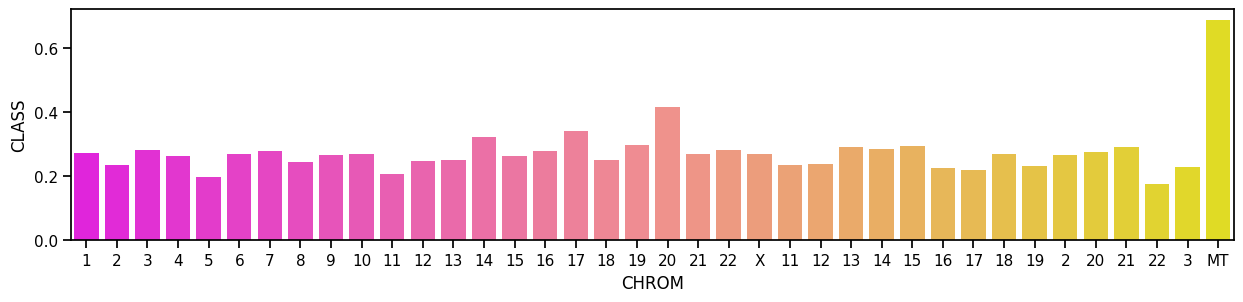

In [54]:
plt.figure(figsize = (15, 3))
dt = data
sns.set_context("notebook")

sns.barplot(x = dt['CHROM'], y =data['CLASS'], palette=("spring"), ci=None)

# Feature Transformation

- Drop **Unnamed: 0**, **Ticker Symbol** and **Period Ending** column as they don't carry any information.
- Drop columns with missing values.
- Make sure all the columns are continuous which is what we need for K-means clustering.
- Transform **Net Income** into a binary column
- Ensure the data is scaled and normally distributed

In [55]:
unique_col = pd.DataFrame([[i, len(data[i].unique())] for i in data.columns],
                          columns=['Variable', 'Unique Values']).set_index('Variable')

to_drop = list(unique_col[unique_col['Unique Values'] > 3000].index)
data.drop(to_drop, axis=1, inplace=True)

In [56]:
pd.DataFrame([[i, len(data[i].unique())] for i in data.columns],
             columns=['Variable', 'Unique Values']).set_index('Variable')

,Unique Values
Variable,
CHROM,38
REF,866
ALT,458
AF_ESP,2842
AF_TGP,2087
CLNDISDBINCL,94
CLNDNINCL,102
CLNSIGINCL,138
CLNVC,7


In [57]:
num_missing = data.isnull().sum()
percentage_missing = data.isnull().sum().apply(lambda x: x/data.shape[0]*100)

In [58]:
missing_data = pd.DataFrame({'Number of Missing':  num_missing,
                             'Percentage of Missing': percentage_missing})

missing_data['Percentage of Missing'].sort_values(ascending = False)

MOTIF_NAME           100.00
MOTIF_SCORE_CHANGE   100.00
HIGH_INF_POS         100.00
MOTIF_POS            100.00
DISTANCE              99.83
SSR                   99.80
CLNDISDBINCL          99.74
CLNDNINCL             99.74
CLNSIGINCL            99.74
INTRON                86.50
PolyPhen              61.96
SIFT                  61.90
BLOSUM62              60.74
BAM_EDIT              50.96
Amino_acids           15.35
Codons                15.35
LoFtool                6.46
MC                     1.30
SYMBOL                 0.02
BIOTYPE                0.02
STRAND                 0.02
Feature_type           0.02
Feature                0.02
REF                    0.00
IMPACT                 0.00
Consequence            0.00
Allele                 0.00
CLASS                  0.00
ORIGIN                 0.00
CLNVC                  0.00
AF_TGP                 0.00
AF_ESP                 0.00
ALT                    0.00
CHROM                  0.00
Name: Percentage of Missing, dtype: float64

In [59]:
drop_list = list(missing_data[missing_data['Percentage of Missing'] >= 20].index)
data.drop(drop_list,axis = 1, inplace=True)

In [60]:
data.isnull().sum()

CHROM               0
REF                 0
ALT                 0
AF_ESP              0
AF_TGP              0
CLNVC               0
MC                846
ORIGIN              0
CLASS               0
Allele              0
Consequence         0
IMPACT              0
SYMBOL             16
Feature_type       14
Feature            14
BIOTYPE            16
Amino_acids     10004
Codons          10004
STRAND             14
LoFtool          4213
dtype: int64

In [61]:
data = data.drop(data[data.CLASS == 1].index)
data = data.drop("CLASS", axis = 1)
data

,CHROM,REF,ALT,AF_ESP,AF_TGP,CLNVC,MC,ORIGIN,Allele,Consequence,IMPACT,SYMBOL,Feature_type,Feature,BIOTYPE,Amino_acids,Codons,STRAND,LoFtool
0,1,G,C,0.08,0.11,single_nucleotide_variant,SO:0001583|missense_variant,1,C,missense_variant,MODERATE,B3GALT6,Transcript,NM_080605.3,protein_coding,E/D,gaG/gaC,1.00,NaN
1,1,G,A,0.00,0.00,single_nucleotide_variant,SO:0001583|missense_variant,1,A,missense_variant,MODERATE,TMEM240,Transcript,NM_001114748.1,protein_coding,P/L,cCg/cTg,-1.00,NaN
3,1,G,A,0.00,0.00,single_nucleotide_variant,SO:0001583|missense_variant,33,A,missense_variant,MODERATE,SKI,Transcript,XM_005244775.1,protein_coding,G/S,Ggc/Agc,1.00,NaN
4,1,G,T,0.00,0.00,single_nucleotide_variant,SO:0001583|missense_variant,33,T,missense_variant,MODERATE,SKI,Transcript,XM_005244775.1,protein_coding,G/C,Ggc/Tgc,1.00,NaN
5,1,G,C,0.00,0.00,single_nucleotide_variant,SO:0001583|missense_variant,33,C,missense_variant,MODERATE,SKI,Transcript,XM_005244775.1,protein_coding,G/R,Ggc/Cgc,1.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65182,X,C,T,0.02,0.01,single_nucleotide_variant,SO:0001819|synonymous_variant,1,T,synonymous_variant,LOW,F8,Transcript,NM_000132.3,protein_coding,P,ccG/ccA,-1.00,0.00
65183,X,T,G,0.08,0.16,single_nucleotide_variant,SO:0001819|synonymous_variant,1,G,synonymous_variant,LOW,F8,Transcript,NM_000132.3,protein_coding,S,tcA/tcC,-1.00,0.00
65185,X,C,T,0.01,0.01,single_nucleotide_variant,SO:0001819|synonymous_variant,1,T,synonymous_variant,LOW,F8,Transcript,NM_000132.3,protein_coding,A,gcG/gcA,-1.00,0.00
65186,X,T,C,0.00,0.00,single_nucleotide_variant,SO:0001819|synonymous_variant,1,C,synonymous_variant,LOW,RAB39B,Transcript,NM_171998.2,protein_coding,T,acA/acG,-1.00,NaN


<AxesSubplot:>

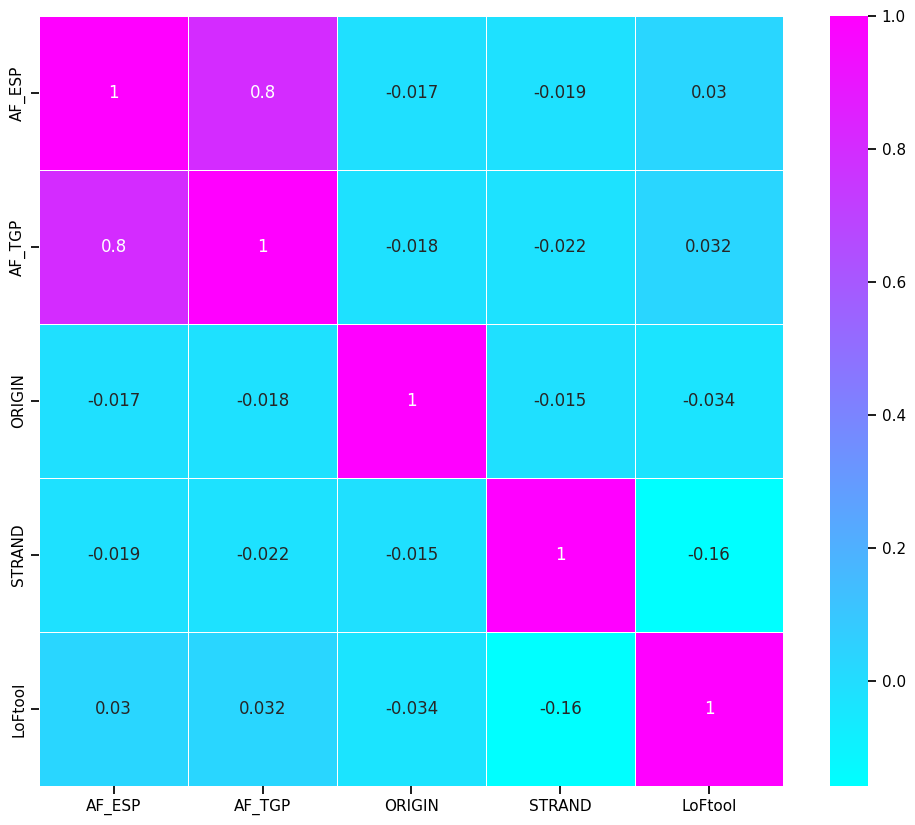

In [62]:
plt.figure(figsize = (12, 10))
sns.heatmap(data.corr(), annot = True, linewidths=.5, cmap = plt.cm.cool)

In [63]:
data.drop(['AF_TGP'],axis = 1, inplace=True)

In [64]:
# check the types
df = pd.DataFrame(data.isnull().sum().astype(int), columns=['Null'])
null_list = list(df[df['Null'] != 0].index)
data[null_list].dtypes

MC               object
SYMBOL           object
Feature_type     object
Feature          object
BIOTYPE          object
Amino_acids      object
Codons           object
STRAND          float64
LoFtool         float64
dtype: object

In [65]:
data[null_list].sample(5)

,MC,SYMBOL,Feature_type,Feature,BIOTYPE,Amino_acids,Codons,STRAND,LoFtool
46658,SO:0001819|synonymous_variant,ITGB2,Transcript,NM_000211.3,protein_coding,V,gtC/gtA,-1.00,0.03
7695,SO:0001583|missense_variant,LEPR,Transcript,NM_002303.5,protein_coding,M/T,aTg/aCg,1.00,0.61
53351,SO:0001583|missense_variant,APC,Transcript,XM_005271975.1,protein_coding,P/S,Cca/Tca,1.00,0.00
17075,SO:0001819|synonymous_variant,FGD4,Transcript,XM_005253304.1,protein_coding,D,gaC/gaT,1.00,0.68
75,SO:0001583|missense_variant,ALPL,Transcript,NM_000478.5,protein_coding,R/H,cGc/cAc,1.00,0.04


In [66]:
data.drop(["Feature_type"],axis = 1, inplace=True)

In [67]:
for x in ["MC", "SYMBOL", "Feature", 
          "BIOTYPE", "STRAND", "Amino_acids", "Codons" ]:
    data[x].fillna(data[x].mode()[0], inplace=True)

data['LoFtool'].fillna(data['LoFtool'].mean(), inplace=True)

data.isnull().sum()

CHROM          0
REF            0
ALT            0
AF_ESP         0
CLNVC          0
MC             0
ORIGIN         0
Allele         0
Consequence    0
IMPACT         0
SYMBOL         0
Feature        0
BIOTYPE        0
Amino_acids    0
Codons         0
STRAND         0
LoFtool        0
dtype: int64

In [68]:
#display the number of unique values for columns type object
dg = pd.DataFrame([[str(i),data[i].dtypes == 'object'] for i in data.columns],
                  columns=['Variable','Object Type']).set_index('Variable')
object_columns_names = list(dg[dg['Object Type'] == True].index)
df = data[object_columns_names]
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns],
                          columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
CHROM,38
REF,707
ALT,379
CLNVC,7
MC,79
Allele,312
Consequence,45
IMPACT,4
SYMBOL,2155


In [69]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['BIOTYPE']

In [70]:
categorical_variables = list(df_uniques[(df_uniques['Unique Values'] > 2)].index)
categorical_variables

['CHROM',
 'REF',
 'ALT',
 'CLNVC',
 'MC',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Feature',
 'Amino_acids',
 'Codons']

In [71]:
for col in categorical_variables:
    data[col] = data[col].apply(lambda x: str(x))

data[categorical_variables].dtypes

CHROM          object
REF            object
ALT            object
CLNVC          object
MC             object
Allele         object
Consequence    object
IMPACT         object
SYMBOL         object
Feature        object
Amino_acids    object
Codons         object
dtype: object

In [72]:
numeric_variables = list(set(data.columns) - set(categorical_variables) - set(binary_variables))
data[numeric_variables].dtypes

LoFtool    float64
ORIGIN       int64
AF_ESP     float64
STRAND     float64
dtype: object

In [73]:
lb, le = LabelBinarizer(), LabelEncoder()

#encoding ordinary variables
for col in categorical_variables:
    data[col] = le.fit_transform(data[col])

# binary encoding binary variables
for col in binary_variables:
    data[col] = lb.fit_transform(data[col])

data.sample(3)

,CHROM,REF,ALT,AF_ESP,CLNVC,MC,ORIGIN,Allele,Consequence,IMPACT,SYMBOL,Feature,BIOTYPE,Amino_acids,Codons,STRAND,LoFtool
6140,0,351,0,0.00,6,78,1,1,43,1,64,657,1,729,1115,1.00,0.42
37210,10,0,178,0.00,6,17,1,135,14,2,1506,667,1,931,177,1.00,0.66
36462,10,180,281,0.01,6,70,1,246,13,3,1674,259,1,511,315,1.00,0.00


<AxesSubplot:>

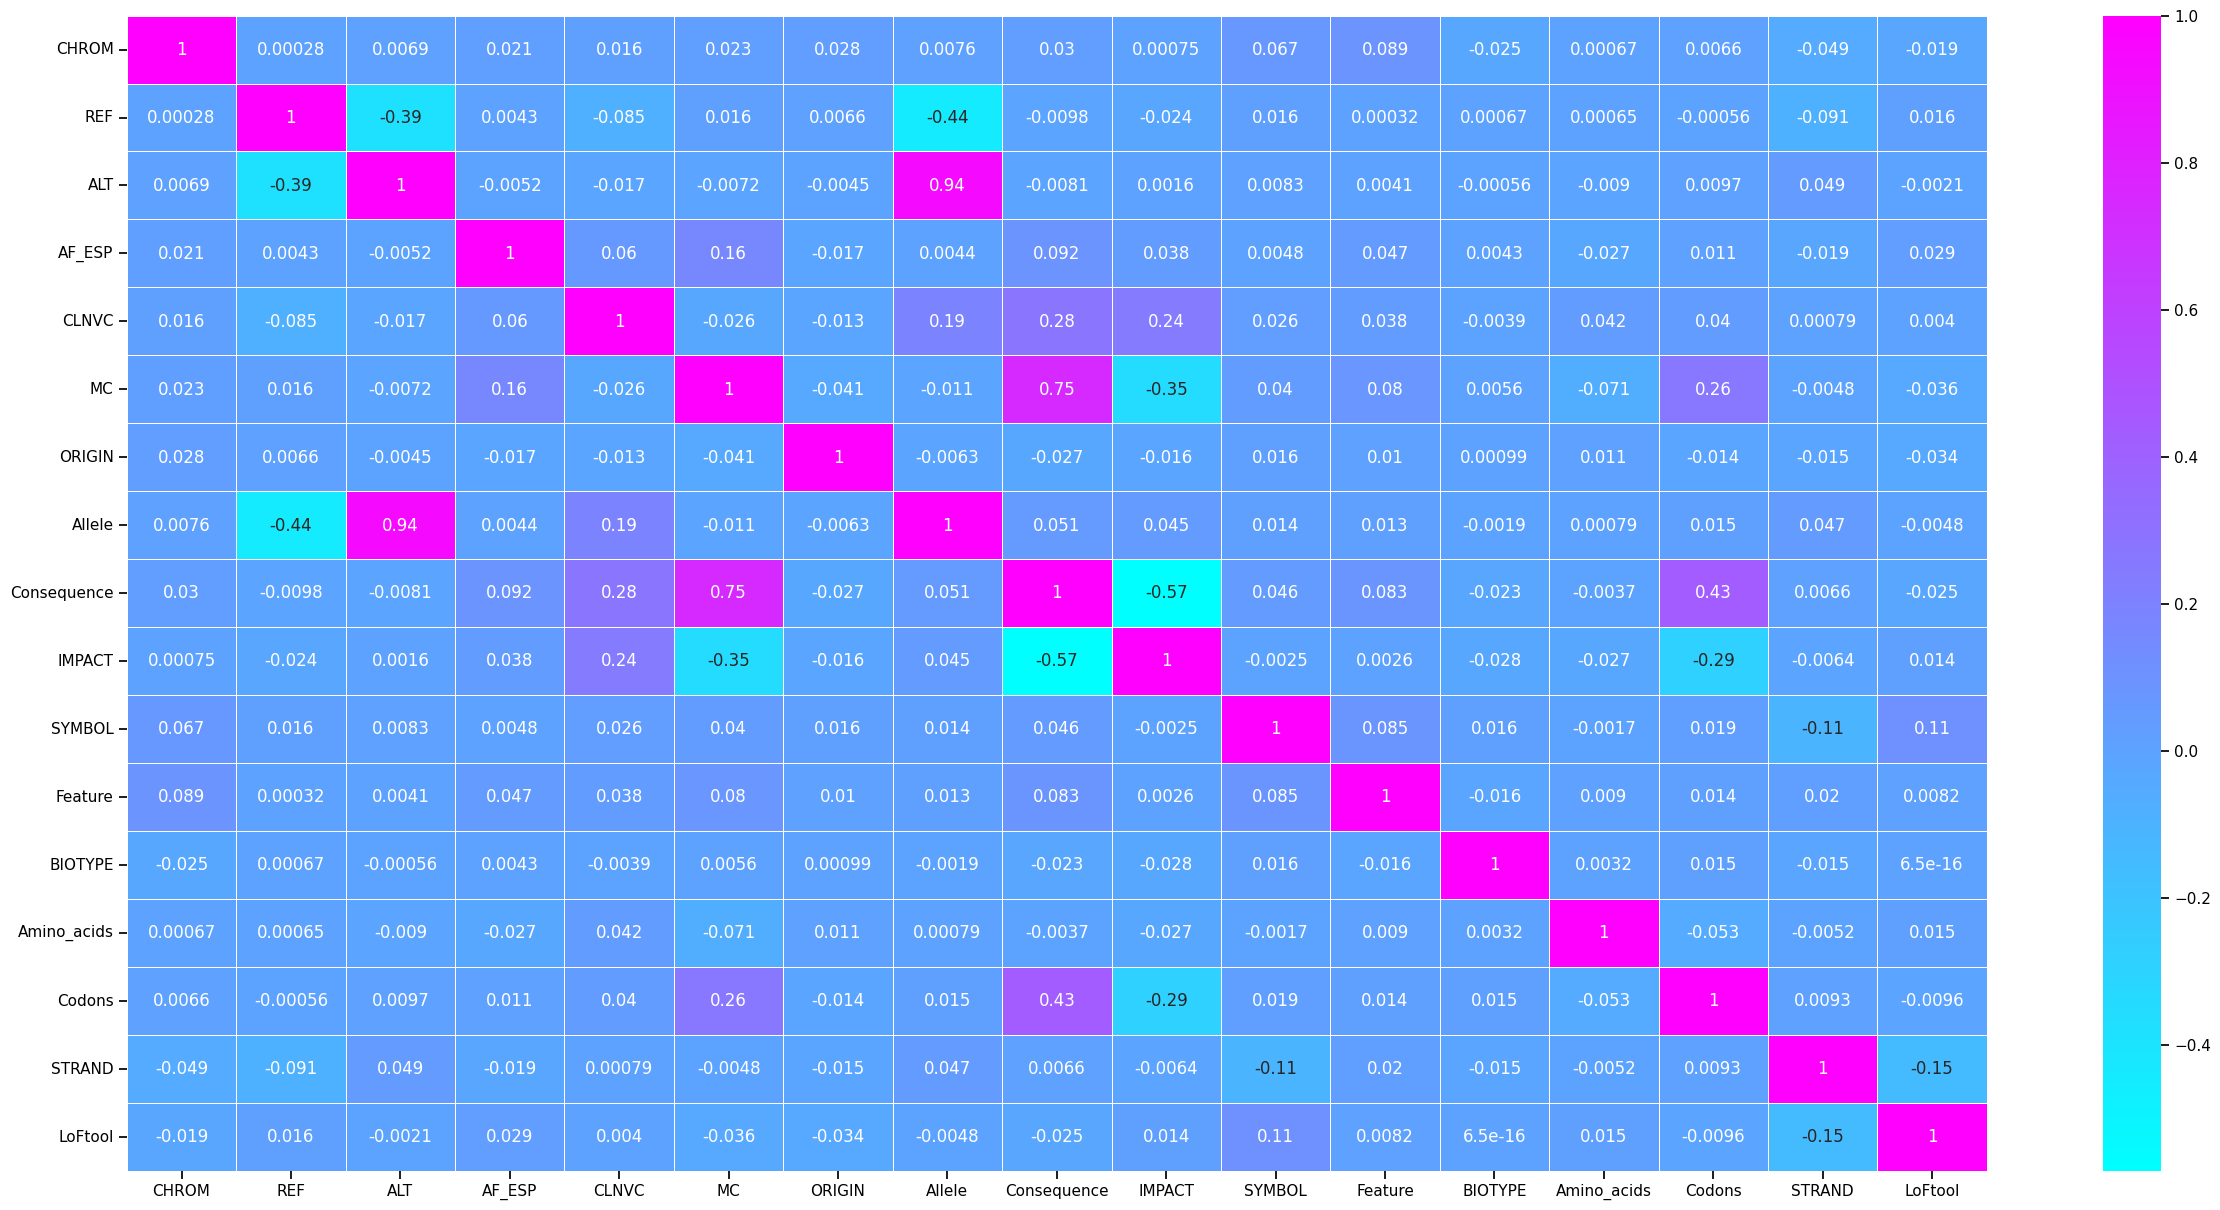

In [74]:
plt.figure(figsize = (30, 15))
sns.heatmap(data.corr(), annot = True, linewidths=.5, cmap = plt.cm.cool)

In [75]:
data.drop(["ALT", "MC"],axis = 1, inplace=True)
categorical_variables.remove('ALT')
categorical_variables.remove("MC")
categorical_variables.remove("CHROM")

In [76]:
categorical_variables

['REF',
 'CLNVC',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Feature',
 'Amino_acids',
 'Codons']

In [77]:
numeric_variables

['LoFtool', 'ORIGIN', 'AF_ESP', 'STRAND']

In [78]:
data[numeric_variables]

,LoFtool,ORIGIN,AF_ESP,STRAND
0,0.35,1,0.08,1.00
1,0.35,1,0.00,-1.00
3,0.35,33,0.00,1.00
4,0.35,33,0.00,1.00
5,0.35,33,0.00,1.00
...,...,...,...,...
65182,0.00,1,0.02,-1.00
65183,0.00,1,0.08,-1.00
65185,0.00,1,0.01,-1.00
65186,0.35,1,0.00,-1.00


In [79]:
lista = [8,11]
data_temp1 = data[data['CHROM'] == 8 ]
data_temp1['CHROM'] = 0
data_temp2 = data[data['CHROM'] == 2 ]
data_temp2['CHROM'] = 1
frame = [data_temp1, data_temp2]
data_clean = pd.concat(frame)
data_clean

/var/folders/l4/fg6v9sxn1cb565zdvp_32l2h0000gn/T/ipykernel_26229/3569804491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp1['CHROM'] = 0
/var/folders/l4/fg6v9sxn1cb565zdvp_32l2h0000gn/T/ipykernel_26229/3569804491.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp2['CHROM'] = 1


,CHROM,REF,AF_ESP,CLNVC,ORIGIN,Allele,Consequence,IMPACT,SYMBOL,Feature,BIOTYPE,Amino_acids,Codons,STRAND,LoFtool
4629,0,180,0.00,6,1,246,14,2,1724,828,1,937,679,1.00,0.28
4630,0,351,0.00,6,1,1,14,2,155,445,1,333,465,1.00,0.14
4631,0,0,0.00,6,1,77,14,2,155,445,1,226,1375,1.00,0.14
4632,0,351,0.00,6,1,1,14,2,155,445,1,101,448,1.00,0.14
4633,0,180,0.00,6,1,1,14,2,155,445,1,87,1396,1.00,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16503,1,180,0.00,6,1,246,28,1,22,2136,1,511,315,1.00,0.29
16506,1,515,0.06,6,1,77,28,1,22,2136,1,511,315,1.00,0.29
16508,1,180,0.00,6,1,246,14,2,22,2136,1,806,322,1.00,0.29
16509,1,351,0.00,6,1,1,14,2,22,2136,1,334,469,1.00,0.29


# Apply Feature Scaling

In [80]:
mm = MinMaxScaler()
for column in [categorical_variables + numeric_variables]:
    data_clean[column] = mm.fit_transform(data_clean[column])

data_clean

,CHROM,REF,AF_ESP,CLNVC,ORIGIN,Allele,Consequence,IMPACT,SYMBOL,Feature,BIOTYPE,Amino_acids,Codons,STRAND,LoFtool
4629,0,0.26,0.00,1.00,0.02,0.80,0.32,0.67,0.81,0.38,1,0.86,0.34,1.00,0.28
4630,0,0.50,0.00,1.00,0.02,0.00,0.32,0.67,0.07,0.20,1,0.30,0.23,1.00,0.14
4631,0,0.00,0.00,1.00,0.02,0.25,0.32,0.67,0.07,0.20,1,0.21,0.69,1.00,0.14
4632,0,0.50,0.00,1.00,0.02,0.00,0.32,0.67,0.07,0.20,1,0.09,0.22,1.00,0.14
4633,0,0.26,0.00,1.00,0.02,0.00,0.32,0.67,0.07,0.20,1,0.08,0.70,1.00,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16503,1,0.26,0.00,1.00,0.02,0.80,0.64,0.33,0.00,0.98,1,0.47,0.16,1.00,0.29
16506,1,0.73,0.11,1.00,0.02,0.25,0.64,0.33,0.00,0.98,1,0.47,0.16,1.00,0.29
16508,1,0.26,0.00,1.00,0.02,0.80,0.32,0.67,0.00,0.98,1,0.74,0.16,1.00,0.29
16509,1,0.50,0.00,1.00,0.02,0.00,0.32,0.67,0.00,0.98,1,0.31,0.23,1.00,0.29


In [81]:
# Save a copy of the processed data for later use
outputfile = '/Users/qasimk/Downloads/ML/data/clinvar_conflicting_processed.csv'
data_clean.to_csv(outputfile, index=False)

In [82]:
data = pd.read_csv('/Users/qasimk/Downloads/ML/data/clinvar_conflicting_processed.csv', sep=',')
data

,CHROM,REF,AF_ESP,CLNVC,ORIGIN,Allele,Consequence,IMPACT,SYMBOL,Feature,BIOTYPE,Amino_acids,Codons,STRAND,LoFtool
0,0,0.26,0.00,1.00,0.02,0.80,0.32,0.67,0.81,0.38,1,0.86,0.34,1.00,0.28
1,0,0.50,0.00,1.00,0.02,0.00,0.32,0.67,0.07,0.20,1,0.30,0.23,1.00,0.14
2,0,0.00,0.00,1.00,0.02,0.25,0.32,0.67,0.07,0.20,1,0.21,0.69,1.00,0.14
3,0,0.50,0.00,1.00,0.02,0.00,0.32,0.67,0.07,0.20,1,0.09,0.22,1.00,0.14
4,0,0.26,0.00,1.00,0.02,0.00,0.32,0.67,0.07,0.20,1,0.08,0.70,1.00,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7974,1,0.26,0.00,1.00,0.02,0.80,0.64,0.33,0.00,0.98,1,0.47,0.16,1.00,0.29
7975,1,0.73,0.11,1.00,0.02,0.25,0.64,0.33,0.00,0.98,1,0.47,0.16,1.00,0.29
7976,1,0.26,0.00,1.00,0.02,0.80,0.32,0.67,0.00,0.98,1,0.74,0.16,1.00,0.29
7977,1,0.50,0.00,1.00,0.02,0.00,0.32,0.67,0.00,0.98,1,0.31,0.23,1.00,0.29


# Split the data

Split the data into train and test data sets using **StratifiedShuffleSplit** to maintain the same ratio of predictor classes.

In [83]:

feature_cols = [x for x in data.columns if x != 'CHROM']
X_data = data[feature_cols]
y_data = data['CHROM']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size= 0.2, random_state=0)


# Train models

- Fit a **K-means clustering** model with two clusters and 
- Fit 2 **Agglomerative clustering** models with two clusters (ward-link and complete-link clustering)
- Compare the results to those obtained by K-means with regards to wine color by reporting the number of red and white observations in each cluster for both K-means and agglomerative clustering.
- Visualize the **dendrogram** produced by agglomerative clustering

## K-means

In [84]:
km = KMeans(n_clusters = 2, random_state=0)
km = km.fit(X_train)

predict_array = km.predict(X_train)

y_traindf = y_train.to_frame(name = "CHROM")
y_traindf['kmeans'] = predict_array.tolist()

y_traindf1 = (y_traindf[['CHROM','kmeans']].groupby(['kmeans','CHROM']).size().to_frame().rename(columns={0:'number'}))
y_traindf1


number
kmeans CHROM        
0      0        1226
       1        2061
1      0        2091
       1        1005

## Agglomerative Clustering

In [85]:
for linkage in ['complete', 'ward']:
    ag = AgglomerativeClustering(n_clusters=2, linkage=linkage, compute_full_tree=True)
    ag = ag.fit(X_train)
    y_traindf[str('agglom_'+linkage)] = ag.fit_predict(X_train)

y_traindf    

,CHROM,kmeans,agglom_complete,agglom_ward
5175,1,1,0,1
597,0,1,0,1
826,0,1,0,1
675,0,1,0,1
402,0,1,0,1
...,...,...,...,...
4931,1,0,0,0
3264,0,1,0,1
1653,0,1,0,1
2607,0,1,1,1


In [86]:
(y_traindf[['CHROM','agglom_ward']]
 .groupby(['CHROM','agglom_ward'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
CHROM agglom_ward        
0     0              1152
      1              2165
1     0              1877
      1              1189

In [87]:
(y_traindf[['CHROM','agglom_complete']]
     .groupby(['CHROM','agglom_complete'])
     .size()
     .to_frame()
     .rename(columns={0:'number'}))

number
CHROM agglom_complete        
0     0                  3114
      1                   203
1     0                  2904
      1                   162

In [88]:
# Comparing AgglomerativeClustering with KMeans
(y_traindf[['CHROM','agglom_complete', 'agglom_ward','kmeans']]
 .groupby(['CHROM', 'agglom_complete', 'agglom_ward', 'kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
CHROM agglom_complete agglom_ward kmeans        
0     0               0           0         1149
                      1           0           27
                                  1         1938
      1               0           0            3
                      1           0           47
                                  1          153
1     0               0           0         1877
                      1           0          119
                                  1          908
      1               1           0           65
                                  1           97

In [89]:
kma = km.predict(X_test)
for linkage in ['complete', 'ward']:
    ag = AgglomerativeClustering(n_clusters=2, linkage=linkage, compute_full_tree=True)
    ag = ag.fit(X_test)
    if linkage == "complete":
        complete = ag.fit_predict(X_test)
    else:
        ward = ag.fit_predict(X_test)    

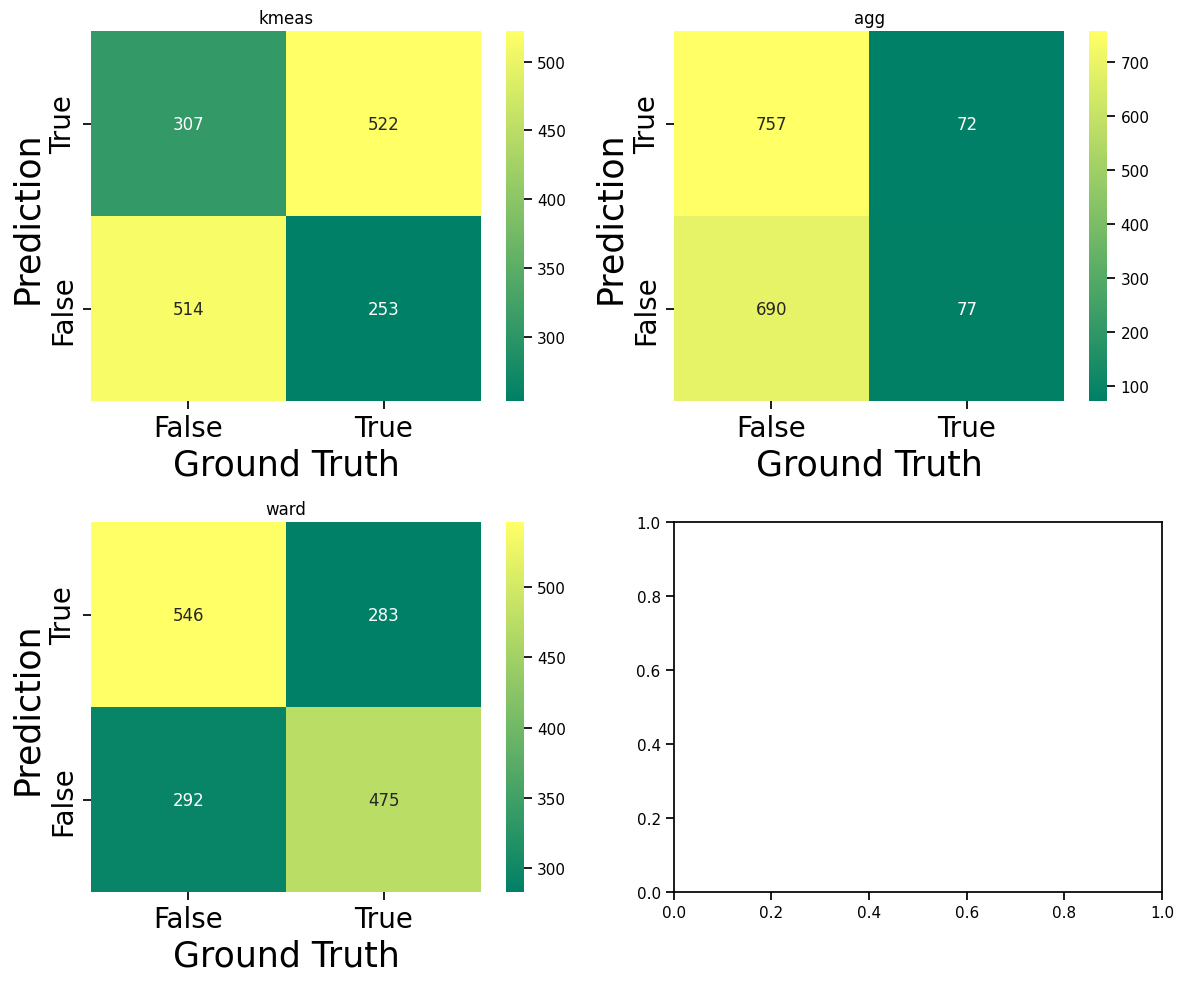

In [90]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)


models = coeff_labels = ['kmeas', 'agg', 'ward']
cm = [confusion_matrix(y_test, kma),
      confusion_matrix(y_test, complete),
      confusion_matrix(y_test, ward)]
labels = ['False', 'True']

for ax,model, idx in zip(axList, models, range(0,3)):
    sns.heatmap(cm[idx], ax=ax, annot=True, fmt='d', cmap='summer');
    ax.set(title=model);
    ax.set_xticklabels(labels, fontsize=20);
    ax.set_yticklabels(labels[::-1], fontsize=20);
    ax.set_ylabel('Prediction', fontsize=25);
    ax.set_xlabel('Ground Truth', fontsize=25)
    
plt.tight_layout()

In [91]:
metrics = pd.DataFrame()
km_stats = pd.DataFrame(classification_report(y_test, kma, output_dict=True)).iloc[:3,:2]
com_stats = pd.DataFrame(classification_report(y_test, complete, output_dict=True)).iloc[:3,:2]
ward_stats = pd.DataFrame(classification_report(y_test, ward, output_dict=True)).iloc[:3,:2]
metrics.append([km_stats, com_stats, ward_stats])

/var/folders/l4/fg6v9sxn1cb565zdvp_32l2h0000gn/T/ipykernel_26229/4001550864.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics.append([km_stats, com_stats, ward_stats])


,0,1
precision,0.37,0.33
recall,0.37,0.33
f1-score,0.37,0.33
precision,0.52,0.52
recall,0.91,0.10
f1-score,0.67,0.17
precision,0.65,0.63
recall,0.66,0.62
f1-score,0.66,0.62


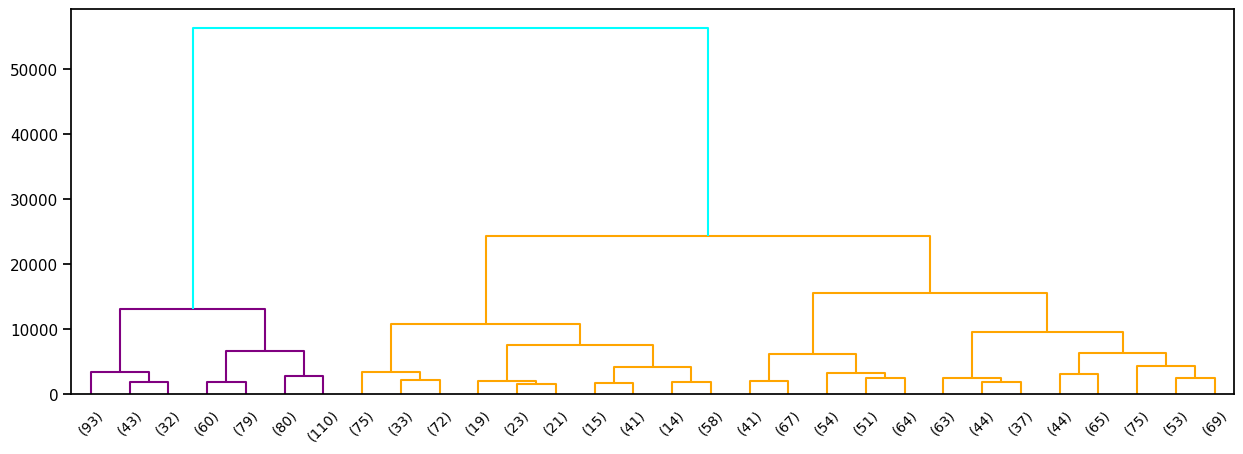

In [92]:
Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))


hierarchy.set_link_color_palette(['purple', 'orange'])

den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color='cyan')

# Results
Comparing the results shows that I am able to predict profit better than loss which is what I expected given that we have more data for companies with profit(1: 1679 vs 0: 102). The best algorithm for predicting loss is the **Complete-link Agglomerative Clustering** model and for predicting profit **KMeans Clustering** seems to be the best candidate althought **Ward-link Agglomerative Clustering** achieved nearly the same result. 

Better result could be achieved by performing PCA or hyperparameter tuning.